# Introduction

Welcome to this Jupyter Notebook, where we delve into the implementation and analysis of an Expectation-Maximization (EM) algorithm, specifically a Generalized EM (GEM) algorithm. The primary goal of this analysis is to estimate the parameters of two distinct Generalized Additive Models (GAMs): one for the signal and another for the background. This task is particularly challenging as we only observe the aggregated sum of these two components.

## Overview of the Dataset

The dataset used in this analysis comprises observations divided across $10000$ squares. Each square is associated with a count of events, providing a rich dataset for our modeling.

## EM Algorithm in a Nutshell

The EM algorithm is a powerful iterative method used in statistics for finding maximum likelihood estimates of parameters in statistical models, where the model depends on unobserved latent variables. In our case, these latent variables are the individual contributions from the signal and background.

## Implementation Details

- **M-Step with `mgcv`:** For fitting the GAM model in the Maximization (M) step, we use the `mgcv` package in R. This package allows us to efficiently update the rate $ \lambda_{ij} $ for each iteration of the algorithm.

- **Data Processing:** While the functions for data processing are detailed within this notebook, we also provide pre-processed data at the beginning of the Analysis section for ease of understanding and reproducibility.

- **Visualization:** To effectively visualize our results, we employ `ggplot` and `RColorBrewer`. These tools aid in creating insightful and aesthetically pleasing graphical representations of our findings.

## Notebook Structure

The notebook is structured as follows:

1. **Main function and libraries:** Provides the libraries necessary, a detailed explanation and implementation of the EM algorithm.
2. **Data Processing:** Outlines the preprocessing steps and presents the pre-processed data.
3. **Analysis:** Code for in-depth analysis of the results obtained from the algorithm, supported by visualizations.
4. **Conclusion:** Summarizes the key findings and potential implications of this study.

We hope this notebook serves as both an educational and practical guide to understanding and implementing the EM algorithm for GAM models in R.


1. [**Main Function and Libraries**](#main-function-and-libraries)
2. [**Data Processing**](#data-processing)
3. [**Analysis**](#analysis)
4. [**Conclusion**](#conclusion)


# Main function and libraries <a id="main-function-and-libraries"></a>

In [19]:
library(mgcv)
library(ggplot2)
library(RColorBrewer)
library(dplyr)



#' Calculate the complete log likelihood for GAM models
#'
#' This function computes the complete log likelihood in the context of Generalized Additive Models (GAM).
#' It uses two GAM models and data containing expected values for signal and background components
#' to compute the log likelihood.
#'
#' @param data A data frame containing the expected values 'E_zi1' and 'E_zi2'.
#' @param gam_model1 The first GAM model, typically representing the signal.
#' @param gam_model2 The second GAM model, typically representing the background.
#' @return The computed log likelihood as a numeric value.
log_likelihood <- function(data, gam_model1, gam_model2) {
  lambda1 <- predict(gam_model1, newdata = data, type = "response")
  lambda2 <- predict(gam_model2, newdata = data, type = "response")
  zi1 <- data$E_zi1
  zi2 <- data$E_zi2
  
  ll1 <- zi1 * log(lambda1) - lambda1 - lgamma(zi1 + 1)
  ll2 <- zi2 * log(lambda2) - lambda2 - lgamma(zi2 + 1)
  
  sum(ll1 + ll2)
}



#' E-step of an algorithm using GAM models
#'
#' This function performs the E-step of an algorithm, taking as input two GAM models,
#' one representing the signal and the other representing the background. It calculates
#' the expected values for signal and background components based on these models.
#' 
#' @param w Observed count.
#' @param gam1 GAM model representing the signal.
#' @param gam2 GAM model representing the background.
#' @param data Data used for predictions.
#' @return A list containing the rounded expected values for signal and background components.
E_step_gam <- function(w, gam1, gam2, data) {
  lambda_i1 <- predict(gam1, newdata=data, type="response")
  lambda_i2 <- predict(gam2, newdata=data, type="response")
  lambda_wi <- lambda_i1 + lambda_i2

  E_zi1 <- w * (lambda_i1 / lambda_wi)
  E_zi2 <- w * (lambda_i2 / lambda_wi)
  
  return(list(E_zi1 = round(E_zi1), E_zi2 = round(E_zi2)))
}


#' Expectation-Maximization Algorithm for GAM Models
#'
#' This function implements the EM algorithm to find parameters for two GAM models,
#' one representing the signal and the other representing the background. It iteratively
#' performs the E-step (using 'E_step_gam') and M-step to update the models until convergence
#' or the maximum number of iterations is reached.
#'
#' @param gam_model1 Initial GAM model for the signal.
#' @param gam_model2 Initial GAM model for the background.
#' @param data Data frame containing the variables 'x1', 'x2', and 'total_count'.
#' @param max_iterations Maximum number of iterations for the EM algorithm (default: 1000).
#' @param sp Smoothing parameter used in the GAM model fitting (default: 0.5).
#' @param k1, k2, k3, k4 Knots for smooth terms in GAM models (defaults: 10).
#' @return A list containing the updated GAM models for signal and background, and the number of iterations.
EM_gam_full <- function(gam_model1, gam_model2, data, max_iterations = 1000, sp = 0.5, k1 = 10, k2 = 10, k3 = 10, k4 = 10) {

  x1 <- data$x1
  x2 <- data$x2
  w <- data$total_count

  convergence_threshold <- 1e-3
  iteration <- 1
  converged <- FALSE

  # Initial E-step with E_step_gam function
  E_vals <- E_step_gam(w, gam_model1, gam_model2, data)
  
  # Initial M-step
  data$E_zi1 <- E_vals$E_zi1
  gam_model_zi1 <- gam(E_zi1 ~ s(x1, k = k1, sp = sp) + s(x2, k = k2, sp = sp), data = data, method = "REML", family = poisson(link = log)) 
  data$E_zi2 <- E_vals$E_zi2
  gam_model_zi2 <- gam(E_zi2 ~ s(x1, k = k3, sp = sp) + s(x2, k = k4, sp = sp), data = data, method = "REML", family = poisson(link = log)) 

  initial_log_likelihood <- log_likelihood(data, gam_model1, gam_model2)

  # EM iterations
  while(!converged && iteration <= max_iterations) {
    # E-step
    E_vals <- E_step_gam(w, gam_model_zi1, gam_model_zi2, data)
    
    # M-step
    data$E_zi1 <- E_vals$E_zi1
    gam_model_zi1 <- gam(E_zi1 ~ s(x1, k = k1, sp = sp) + s(x2, k = k2, sp = sp), data = data, method = "REML", family = poisson(link = log)) 
    data$E_zi2 <- E_vals$E_zi2
    gam_model_zi2 <- gam(E_zi2 ~ s(x1, k = k3, sp = sp) + s(x2, k = k4, sp = sp), data = data, method = "REML", family = poisson(link = log)) 

    # Check for convergence
    current_log_likelihood <- log_likelihood(data, gam_model_zi1, gam_model_zi2)
  
    if (abs(current_log_likelihood - initial_log_likelihood) < convergence_threshold) {
        converged <- TRUE
    } else {
        initial_log_likelihood <- current_log_likelihood
        iteration <- iteration + 1
    }
  }

  return(list(model1 = gam_model_zi1, model2 = gam_model_zi2, iterations = iteration))
}


# Data Processing <a id="data-processing"></a>

In [2]:
file_path1 <- "data/mcsets_labeled/bc3_mc_bg_g1_central.dat"
file_path2 <- "data/mcsets_labeled/bc3_mc_sig_g1_central.dat"

data1 <- read.table(file_path1, header=FALSE)
data2 <- read.table(file_path2, header=FALSE)

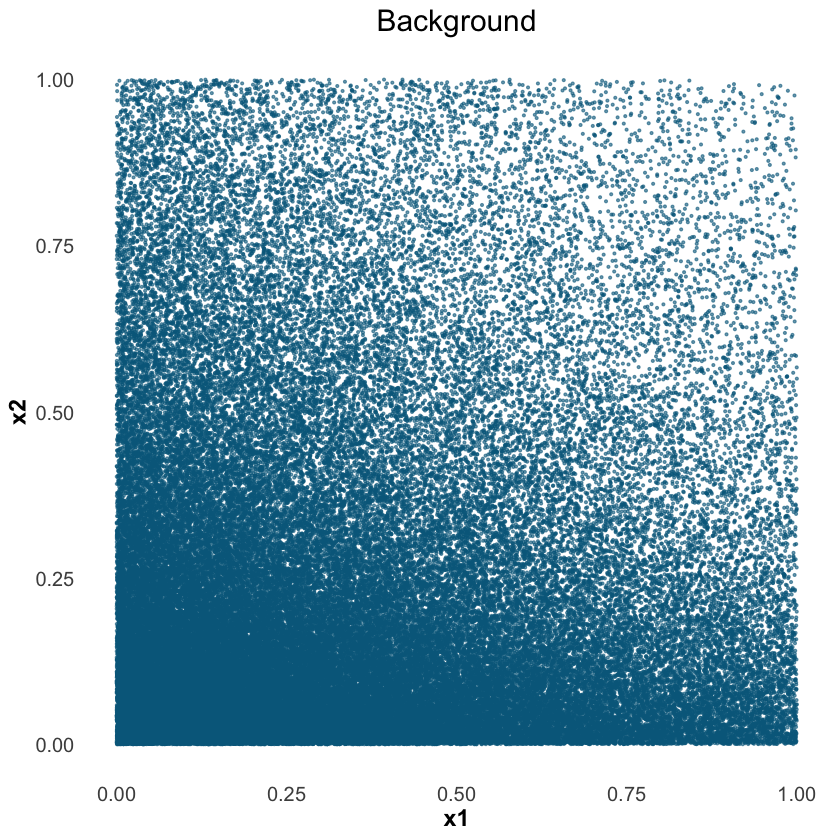

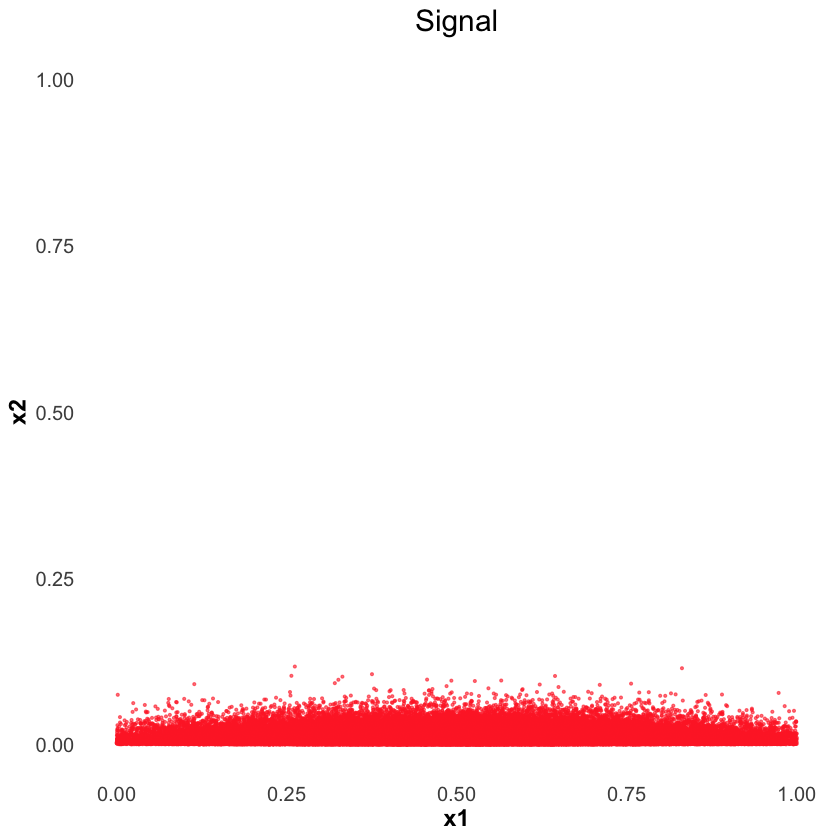

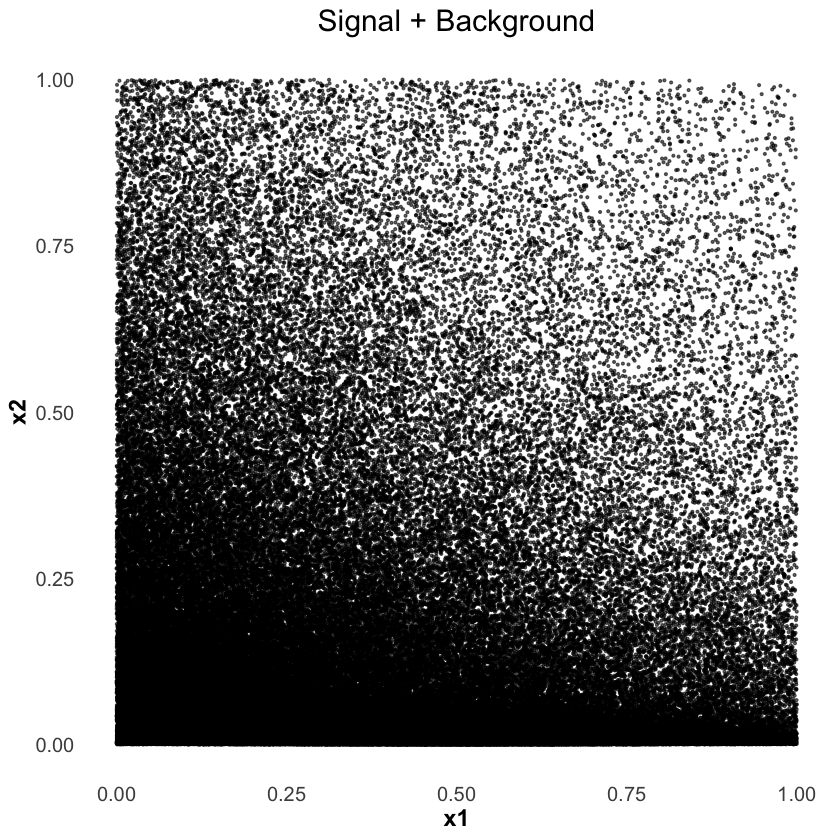

In [3]:

plot1 <- ggplot(data1, aes(x = V1, y = V2)) +
  geom_point(color = "deepskyblue4", shape = 19, alpha = 0.6, size = 0.5) +
  labs(x = "x1", y = "x2",title = "Background") +
  theme_minimal() +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        plot.title = element_text(hjust = 0.5,size=18))

# Enhanced Plot for Data 2
plot2 <- ggplot(data2, aes(x = V1, y = V2)) +
  geom_point(color = "firebrick1", shape = 19, alpha = 0.6, size = 0.5) +
  labs(x = "x1", y = "x2",title = "Signal") +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal() +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        plot.title = element_text(hjust = 0.5,size=18))

plot3 <- ggplot() +
  geom_point(data = data1, aes(x = V1, y = V2), color = "black", shape = 19, alpha = 0.6, size = 0.5) +
  geom_point(data = data2, aes(x = V1, y = V2), color = "black", shape = 19, alpha = 0.6, size = 0.5) +
  labs(x = "x1", y = "x2",title = "Signal + Background") +
  theme_minimal() +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14, face = "bold"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        plot.title = element_text(hjust = 0.5,size=18))

print(plot1)
print(plot2)
print(plot3)

In [8]:
#Data discretization into 10000 squares
data_sign <- read.table("data/mcsets_labeled/bc3_mc_sig_g1_central.dat", header = FALSE, col.names = c("X", "Y"))
grid_data_signal <- data.frame(x1 = numeric(0), x2 = numeric(0), count = integer(0))

num_squares <- 100

x_centers <- seq(0.005, 0.995, length.out = num_squares)
y_centers <- seq(0.005, 0.995, length.out = num_squares)

for (x_center in x_centers) {
  for (y_center in y_centers) {
    x_left <- x_center - 0.005  
    x_right <- x_center + 0.005
    y_bottom <- y_center - 0.005  
    y_top <- y_center + 0.005
    
    points_in_square <- data_sign %>%
      filter(X >= x_left & X < x_right & Y >= y_bottom & Y < y_top)
    
    row <- data.frame(x1 = x_center, x2 = y_center, count = nrow(points_in_square))
    
    grid_data_signal <- bind_rows(grid_data_signal, row)
  }
}

# Analysis <a id="analysis"></a>

In our dataset, each observation includes two key components:

- `zi1` corresponds to the **signal count**. This is the count of events attributed to the signal we are interested in.
- `zi2` corresponds to the **background counts**. These are the counts of events that constitute the background noise or interference.

For our analysis, we fit two separate Generalized Additive Models (GAMs) to these components:

1. **GAM for the Signal**: We model the `zi1` (signal count) using a GAM. This model helps us understand and predict the behavior of the signal component in our data.
2. **GAM for the Background**: Similarly, we model `zi2` (background counts) with another GAM. This is crucial for distinguishing the background noise from the signal.

The fitting of these models is performed using the `mgcv` package in R. This package is specifically designed for building and analyzing GAMs and offers robust capabilities for modeling complex data patterns found in our signal and background counts.


## Loading processed dataset

In [20]:
#training set
merged_df_x1x2 <- read.csv("data/processed/merged_df_x1x2.csv")

#test sets
merged1 <- read.csv("data/processed/merged1.csv")
merged2 <- read.csv("data/processed/merged2.csv")
merged3 <- read.csv("data/processed/merged3.csv")
merged4 <- read.csv("data/processed/merged4.csv")
merged5 <- read.csv("data/processed/merged5.csv")
merged6 <- read.csv("data/processed/merged6.csv")
all_data <- list(merged1,merged2,merged3,merged4,merged5,merged6,merged_df_x1x2)


## Signal analysis

In [10]:
gam_model <- gam(zi1 ~ s(x1) + s(x2), data = merged_df_x1x2, family = poisson(link=log))
summary(gam_model)


Family: poisson 
Link function: log 

Formula:
zi1 ~ s(x1) + s(x2)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -43.5889     0.1639    -266   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
        edf Ref.df Chi.sq p-value    
s(x1) 8.613  8.953  33600  <2e-16 ***
s(x2) 1.000  1.000  89802  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.998   Deviance explained = 99.9%
UBRE = -0.90445  Scale est. = 1         n = 10000


Method: UBRE   Optimizer: outer newton
full convergence after 9 iterations.
Gradient range [-2.600454e-09,2.349949e-06]
(score -0.9044511 & scale 1).
Hessian positive definite, eigenvalue range [2.600386e-09,6.30765e-05].
Model rank =  19 / 19 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

        k'  edf k-index p-value    
s(x1) 9.00 8.61    0.98    0.12    
s(x2) 9.00 1.00    0.94  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


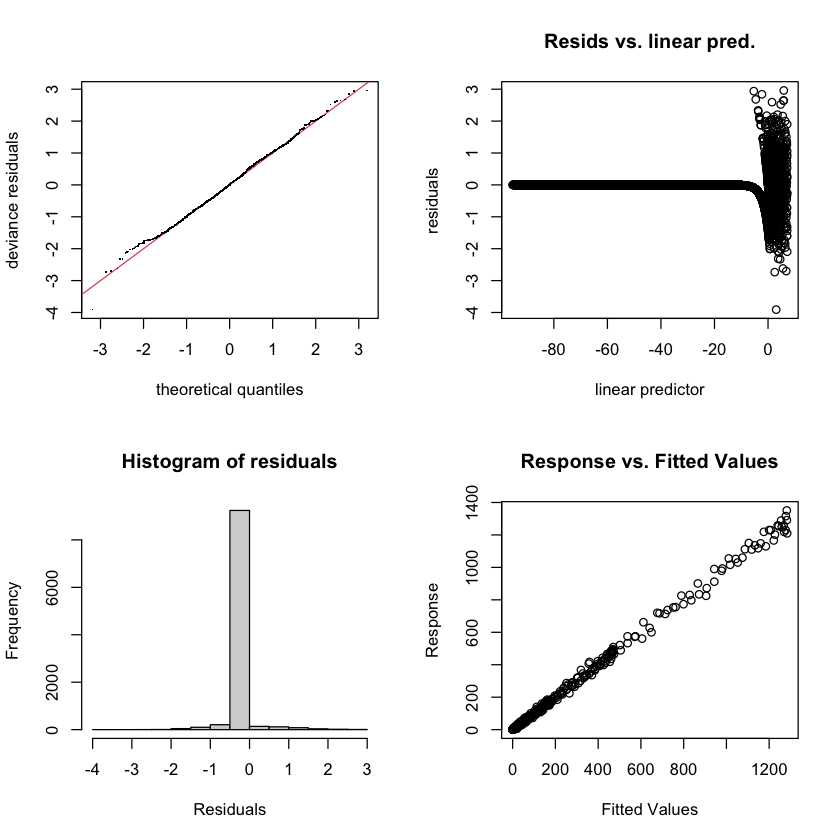

In [11]:
gam.check(gam_model)

## Background analysis

In [12]:
gam_model2 <- gam(zi2 ~ s(x1) + s(x2), data = merged_df_x1x2, family = poisson(link=log))
summary(gam_model2)


Family: poisson 
Link function: log 

Formula:
zi2 ~ s(x1) + s(x2)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 1.672009   0.005127   326.1   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
        edf Ref.df Chi.sq p-value    
s(x1) 1.479  1.815  26619  <2e-16 ***
s(x2) 7.415  8.319  84174  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.951   Deviance explained = 92.1%
UBRE = 0.06338  Scale est. = 1         n = 10000


Method: UBRE   Optimizer: outer newton
full convergence after 8 iterations.
Gradient range [-2.473326e-07,8.319568e-07]
(score 0.06337953 & scale 1).
Hessian positive definite, eigenvalue range [2.772586e-05,0.0001568383].
Model rank =  19 / 19 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

        k'  edf k-index p-value   
s(x1) 9.00 1.48    0.96    0.01 **
s(x2) 9.00 7.42    1.01    0.90   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


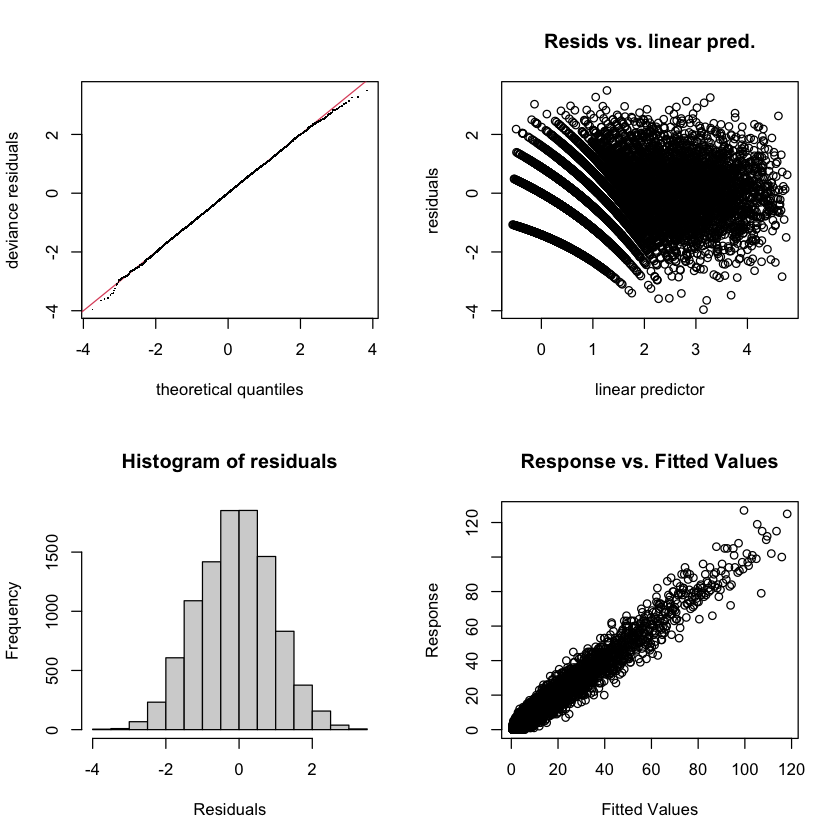

In [13]:
gam.check(gam_model2)

# EM algorithm

For the EM algorithm, we use the gam model trained as input for the starting parameters. It allows us to directly compute the rate for the E-step 0. The difference observed to end the algorithm can be chosen.

In [14]:
#Possible other initializations
gam31 <- gam(zi1 ~ s(x1) + s(x2), data = merged3, family = poisson(link=log))
gam32 <- gam(zi2 ~ s(x1) + s(x2), data = merged3, family = poisson(link=log))

gam51 <- gam(zi1 ~ s(x1) + s(x2), data = merged5, family = poisson(link=log))
gam52 <- gam(zi2 ~ s(x1) + s(x2), data = merged5, family = poisson(link=log))

In [15]:
#Main model used with initialization from parameters of GAM of training dataset
result_all_data <- list()
result1 <- list()

for (i in 1:6) {
  gam_all_data <- EM_gam_full(gam_model, gam_model2, all_data[[i]], max_iterations = 1000,sp=0.5,k2=3)
  result_all_data[[i]] <- list(model1 = gam_all_data$model1, model2 = gam_all_data$model2, iterations = gam_all_data$iteration)
  
  a <- predict(gam_all_data$model1, newdata = all_data[[i]], type = "response")
  result1[[i]] <- sum(a)
  print(i)
  print(result1[[i]])
}

[1] 1
[1] 100210
[1] 2
[1] 99982
[1] 3
[1] 98648
[1] 4
[1] 99353
[1] 5
[1] 110074
[1] 6
[1] 99842


In [16]:
# Model used with initialization from parameters of GAM of dataset 3
result_all_data3 <- list()
result3 <- list()

for (i in 1:6) {
  gam_all_data <- EM_gam_full(gam31, gam32, all_data[[i]], max_iterations = 1000,sp=0.5,k2=3)
  result_all_data3[[i]] <- list(model1 = gam_all_data$model1, model2 = gam_all_data$model2, iterations = gam_all_data$iteration)
  
  a <- predict(gam_all_data$model1, newdata = all_data[[i]], type = "response")
  result3[[i]] <- sum(a)
  print(i)
  print(result3[[i]])
}

[1] 1
[1] 100210
[1] 2
[1] 99982
[1] 3
[1] 98992
[1] 4
[1] 99353
[1] 5
[1] 111105
[1] 6
[1] 99874


In [17]:
# Model used with initialization from parameters of GAM of dataset 5
result_all_data5 <- list()
result5 <- list()

for (i in 1:6) {
  gam_all_data <- EM_gam_full(gam51, gam52, all_data[[i]], max_iterations = 1000,sp=0.5,k2=3)
  result_all_data5[[i]] <- list(model1 = gam_all_data$model1, model2 = gam_all_data$model2, iterations = gam_all_data$iteration)
  
  a <- predict(gam_all_data$model1, newdata = all_data[[i]], type = "response")
  result5[[i]] <- sum(a)
  print(i)
  print(result5[[i]])
}

[1] 1
[1] 100210
[1] 2
[1] 99624
[1] 3
[1] 98507
[1] 4
[1] 99255
[1] 5
[1] 106268
[1] 6
[1] 99842


In [18]:
# Model used with initialization from parameters of GAM of dataset 5 with 25 degrees of freedom

result_all_data5_2 <- list()
result5_2 <- list()

for (i in 1:6) {
  gam_all_data <- EM_gam_full(gam51, gam52, all_data[[i]], max_iterations = 1000,sp=0.5,k1=25,k2=25,k3=25,k4=25)
  result_all_data5_2[[i]] <- list(model1 = gam_all_data$model1, model2 = gam_all_data$model2, iterations = gam_all_data$iteration)
  
  a <- predict(gam_all_data$model1, newdata = all_data[[i]], type = "response")
  result5_2[[i]] <- sum(a)
  print(i)
  print(result5_2[[i]])
}

[1] 1
[1] 100161
[1] 2
[1] 98841
[1] 3
[1] 98167
[1] 4
[1] 99199
[1] 5
[1] 102229
[1] 6
[1] 99901


## Simulations 

### Initalization with parameters from training set

In [ ]:
#Dataframe of EM fitting on 100 simulated dataset. We keep the simulations, the estimates and the standard errors.
set.seed(123)

df_list <- list()
model_list <- list()


for (j in 1:6) {
  data <- all_data[[j]]

  for (i in 1:100) {
    df <- data %>% select(x1, x2)

    #simulation
    simulated_zi1 <- rpois(nrow(data), data$zi1)
    simulated_zi2 <- rpois(nrow(data), data$zi2)
    total_counts <- simulated_zi1 + simulated_zi2
    df$total_count <- total_counts

    df[paste0("simulated_zi1_", i, "_", j)] <- simulated_zi1
    df[paste0("simulated_zi2_", i, "_", j)] <- simulated_zi2
    
    #EM fitting
    gam_all_data <- EM_gam_full(gam_model, gam_model2, df, max_iterations = 1000,k2=3,sp=0.3)
      
    model_list[[paste0("gam_model_", i, "_", j)]] <- gam_all_data$model1
    model_list[[paste0("gam_model2_", i, "_", j)]] <- gam_all_data$model2


    preds_signal <- predict(gam_all_data$model1, newdata = df, type = "response", se.fit = TRUE)
    df[paste0("pred_signal_", i, "_", j)] <- preds_signal$fit
    df[paste0("se_signal_", i, "_", j)] <- preds_signal$se.fit

    preds_background <- predict(gam_all_data$model2, newdata = df, type = "response", se.fit = TRUE)
    df[paste0("pred_background_", i, "_", j)] <- preds_background$fit
    df[paste0("se_background_", i, "_", j)] <- preds_background$se.fit

    df_list[[paste0("iteration_", i, "_dataset_", j)]] <- select(df, -total_count)
  }
}
final_df <- df_list[[1]]

for (k in 2:length(df_list)) {
  final_df <- merge(final_df1, df_list[[k]], by = c("x1", "x2"), all = TRUE)
}


In [ ]:
#Confidence interval

CI_model1_signal <- list()
CI_model1_back <- list()

for (j in 1:length(all_data)) {
  number_ci_signal <- 0
  number_ci_back <- 0
  
  for (i in 1:100) {
      current_pred_signal_col <- paste0("pred_signal_", i, "_", j)
      current_pred_background_col <- paste0("pred_background_", i, "_", j)
      
      current_simulated_zi1_col <- paste0("simulated_zi1_", i, "_", j)
      current_simulated_zi2_col <- paste0("simulated_zi2_", i, "_", j)
      
      sum1 = sum(final_df[current_simulated_zi1_col])
      sum2 = sum(final_df[current_simulated_zi2_col])
      
      est1 = sum(final_df[current_pred_signal_col])
      est2 = sum(final_df[current_pred_background_col])
      
      ci_lower_signal <- est1 - sqrt(est1)
      ci_upper_signal <- est1 + sqrt(est1)


      ci_lower_background <- est2 - sqrt(est2)
      ci_upper_background <- est2 + sqrt(est2)
      
      
      result1 <- 1*(sum1 >= sum(ci_lower_signal) & sum1<= sum(ci_upper_signal))
      result2 <- 1*(sum2 >= sum(ci_lower_background) & sum2 <= sum(ci_upper_background))
      
      number_ci_signal <- number_ci_signal + result1
      number_ci_back <- number_ci_back + result2


  }
  CI_model1_signal[[j]] <- number_ci_signal
  CI_model1_back[[j]] <- number_ci_back
}  

CI_model1_signal 

In [ ]:
# Error for simulated dataset
list_error_signal_df <- list()
list_error_background_df <- list()

for (j in 1:length(all_data)) {
  error_signal_df <- data.frame(x1 = numeric(), x2 = numeric(), negative_error_count = integer(), positive_error_count = integer(), average_error = numeric())
  error_background_df <- data.frame(x1 = numeric(), x2 = numeric(), negative_error_count = integer(), positive_error_count = integer(), average_error = numeric())

  for (i in 1:100) {
    current_pred_signal_col <- paste0("pred_signal_", i, "_", j)
    current_pred_background_col <- paste0("pred_background_", i, "_", j)
    current_simulated_zi1_col <- paste0("simulated_zi1_", i, "_", j)
    current_simulated_zi2_col <- paste0("simulated_zi2_", i, "_", j)

      
    error_signal_info <- final_df %>%
      mutate(error_signal = get(current_pred_signal_col) - get(current_simulated_zi1_col)) %>%
      select(x1, x2, error_signal)

    aggregated_error_signal <- error_signal_info %>%
      group_by(x1, x2) %>%
      summarize(
        positive_error_count = sum(error_signal > 0),
        average_error = mean(error_signal, na.rm = TRUE),
        .groups = "drop"
      )
      
    error_background_info <- final_df %>%
      mutate(error_background = get(current_pred_background_col) - get(current_simulated_zi2_col)) %>%
      select(x1, x2, error_background)

    aggregated_error_background <- error_background_info %>%
      group_by(x1, x2) %>%
      summarize(
        positive_error_count = sum(error_background > 0),
        average_error = mean(error_background, na.rm = TRUE),
        .groups = "drop"
      )

    error_signal_df <- rbind(error_signal_df, aggregated_error_signal)
    error_background_df <- rbind(error_background_df, aggregated_error_background)
  }
  
  
  error_signal_df <- error_signal_df %>%
   group_by(x1, x2) %>%
   summarize(
     total_positive_error_count = sum(positive_error_count)/100,
     total_average_error = mean(average_error, na.rm = TRUE),
     .groups = "drop"
   )

  error_background_df <- error_background_df %>%
   group_by(x1, x2) %>%
   summarize(
     total_positive_error_count = sum(positive_error_count)/100,
     total_average_error = mean(average_error, na.rm = TRUE),
     .groups = "drop"
   )

  list_error_signal_df[[paste0("dataset_", j)]] <- error_signal_df
  list_error_background_df[[paste0("dataset_", j)]] <- error_background_df
}

In [ ]:
#Heatmaps of average error over the simulated dataset
for (j in 1:6) {
  dataset_name <- paste0("dataset_", j)
  data <- list_error_signal_df[[dataset_name]]
  filtered_data <- data[data$x2 < 0.15, ]  
    
  colors <- colorRampPalette(rev(brewer.pal(9, "RdYlBu")))(100)
  

  heatmap_plot <- ggplot(filtered_data, aes(x = x1, y = x2, fill = total_average_error)) +
    geom_tile(color = "white", size = 0.1) +
    scale_fill_gradientn(colors = colors, limits = range(filtered_data$total_average_error, na.rm = TRUE), 
                           name = "Error") +
    labs(x = ifelse(j == 6, "X1", ""), y = "X2", title = paste("Dataset", j)) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, vjust = 1.1, size = 14, color = "black", face = "bold"),
      axis.title.x = element_text(size = 12, vjust = 0.5),
      axis.text.x = element_text(size = 10),
      axis.title.y = element_text(size = 12, vjust = 0.5),
      axis.text.y = element_text(size = 10),
      legend.title = element_text(size = 10),
      legend.text = element_text(size = 8)
    ) +
    coord_fixed(ratio = 1)

  if (j != 6) {
    heatmap_plot <- heatmap_plot +
      theme(
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()
      )
  }
  print(heatmap_plot)
}

In [ ]:
#Heatmaps of average deviance residuals over the simulated dataset
list_residuals <- list()

for (j in 1:length(all_data)) {
  residuals_signal_df <- data.frame(x1 = numeric(), x2 = numeric(), average_residuals = numeric())

  for (i in 1:100) {
    current_pred_signal_col <- paste0("pred_signal_", i, "_", j)
    current_simulated_zi1_col <- paste0("simulated_zi1_", i, "_", j)

    residuals_signal_info <- final_df %>%
      mutate(deviance_residuals = sign(get(current_simulated_zi1_col) - get(current_pred_signal_col)) * 
             sqrt(2 * (get(current_simulated_zi1_col) * log(ifelse(get(current_simulated_zi1_col) == 0, 1, get(current_simulated_zi1_col) / get(current_pred_signal_col))) - 
                       (get(current_simulated_zi1_col) - get(current_pred_signal_col))))) %>%
      select(x1, x2, deviance_residuals)

    aggregated_residuals_signal <- residuals_signal_info %>%
      group_by(x1, x2) %>%
      summarize(
        average_deviance_residuals = mean(deviance_residuals, na.rm = TRUE),
        .groups = "drop"
      )
      
    residuals_signal_df <- rbind(residuals_signal_df, aggregated_residuals_signal)
  }
  
  residuals_signal_df <- residuals_signal_df %>%
    group_by(x1, x2) %>%
    summarize(
      total_average_deviance_residuals = mean(average_deviance_residuals, na.rm = TRUE),
      .groups = "drop"
    )

  list_residuals[[paste0("dataset_", j)]] <- residuals_signal_df
}


In [ ]:
#Deviance residuals for simulated dataset

for (j in 1:6) {
  dataset_name <- paste0("dataset_", j)
  data <- list_residuals[[dataset_name]]
  filtered_data <- data[data$x2 < 0.15, ] 
    
  colors <- colorRampPalette(rev(brewer.pal(9, "RdYlBu")))(100)
  
  heatmap_plot <- ggplot(filtered_data, aes(x = x1, y = x2, fill = total_average_deviance_residuals)) +
    geom_tile(color = "white", size = 0.1) +
    scale_fill_gradientn(colors = colors, limits = range(filtered_data$total_average_deviance_residuals, na.rm = TRUE), 
                         name = "Deviance\nResiduals") +
    labs(x = ifelse(j == 6, "X1", ""), y = "X2", title = paste("Dataset", j)) +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, vjust = 1.1, size = 20, color = "black", face = "bold"),
      axis.title.x = element_text(size = 18, vjust = 0.5), 
      axis.text.x = element_text(size = 16),  
      axis.title.y = element_text(size = 18, vjust = 0.5),  
      axis.text.y = element_text(size = 16),  
      legend.title = element_text(size = 18),  
      legend.text = element_text(size = 16)   
    )

  # Save the heatmap plot
  print(heatmap_plot)
}

In [ ]:
# Plots of predictions with EM algorithm for x2 == 0.005
for (i in 1:6) {

  all_data[[i]]$gam_prediction <- predict(models[[i]]$model1, newdata = all_data[[i]], type = "response")
  all_data[[i]]$gam_prediction_back <- predict(models[[i]]$model2, newdata = all_data[[i]], type = "response")

  # Now filter the data for x2 == 0.005
  data_subset <- filter(all_data[[i]], x2 == 0.005 )

  heatmap_plot <- ggplot(data_subset, aes(x = x1)) + 
    geom_line(aes(y = zi1, colour = "Signal")) +  
    geom_line(aes(y = zi2, colour = "Background")) +  
    geom_line(aes(y = total_count, colour = "Sum")) +  
    geom_line(aes(y = gam_prediction, colour = "EM Signal")) +
    geom_line(aes(y = gam_prediction_back, colour = "EM Background")) +
    labs(title = paste("Dataset", i), x = "x1", y = "count") +
    scale_colour_manual("Legend", 
                        breaks = c("Signal", "Background", "Sum", "EM Signal","EM Background"),
                        values = c("blue", "red", "green", "purple",'black')) +
    theme_minimal()+
    theme(
      plot.title = element_text(hjust = 0.5, vjust = 1.1, size = 20, color = "black", face = "bold"),
      axis.title.x = element_text(size = 18, vjust = 0.5),  
      axis.text.x = element_text(size = 12),  
      axis.title.y = element_text(size = 18, vjust = 0.5),  
      axis.text.y = element_text(size = 12),  
      legend.position = "none",  
    
  )
    print(heatmap_plot)
}


In [ ]:
# Response vs. Fitted Values plot
for (i in list(3,5)) {
    predictions_i1 <- predict(result_all_data2[[i]]$model1, newdata = all_data[[i]], type = "response")
    mock <- all_data[[i]]
    mock$predictions_i1 <- predictions_i1
    plot(mock$predictions_i1, mock$zi1, xlab = "Fitted Values", ylab = "Actual Values", main = "Response vs. Fitted Values")
    abline(0, 1, col = "red")  
}

## Modification of dataset 5

In [ ]:
#Dataset 5
for (i in list(0.005,0.015,0.025)) {
  plot_title <- if(i == 0.005) "Dataset 5 for x2 =" else "x2 ="

  merged5$gam_prediction <- predict(models[[5]]$model1, newdata = merged5, type = "response")
  merged5$gam_prediction_back <- predict(models[[5]]$model2, newdata = merged5, type = "response")
  merged5$sum_predict <- merged5$gam_prediction + merged5$gam_prediction_back

  # Now filter the data for x2 == 0.005
  data_subset <- filter(merged5, x2 == i )

  heatmap_plot <- ggplot(data_subset, aes(x = x1)) + 
    geom_line(aes(y = zi1, colour = "Signal")) +  # Labeling zi1 as "Signal"
    geom_line(aes(y = zi2, colour = "Background")) +  # Labeling zi2 as "Background"
    geom_line(aes(y = total_count, colour = "Sum")) +  # Adding the sum of zi1 and zi2
    geom_line(aes(y = gam_prediction, colour = "EM Signal")) +
    geom_line(aes(y = gam_prediction_back, colour = "EM Background")) +
    geom_line(aes(y = sum_predict, colour = "Sum Prediction")) +
    labs(title = paste(plot_title, i), x = "x1", y = "count") +
    scale_colour_manual("Legend", 
                        breaks = c("Signal", "Background", "Sum", "EM Signal","EM Background","Sum Prediction"),
                        values = c("blue", "red", "green", "purple",'black','forest green')) +
    theme_minimal()+
    theme(
      plot.title = element_text(hjust = 0.5, vjust = 1.1, size = 20, color = "black", face = "bold"),
      axis.title.x = element_text(size = 18, vjust = 0.5),  # Increase axis title size
      axis.text.x = element_text(size = 12),  # Increase axis text size
      axis.title.y = element_text(size = 18, vjust = 0.5),  # Increase axis title size
      axis.text.y = element_text(size = 12),  # Increase axis text size
      legend.position = "none",  # This will remove the legend 
  )
    ggsave(paste0("Dataset_", i, ".png"), plot = heatmap_plot)
    print(heatmap_plot)
}


In [ ]:
#Modified dataset 5
new5 <- merged5

new5$zi2 <- ifelse(new5$x2 == 0.005  & (new5$x1) < 0.995, new5$zi2 - 85*(1-new5$x1), new5$zi2)
new5$zi2 <- ifelse(new5$x2 == 0.015 , new5$zi2 - 50*(1-new5$x1), new5$zi2)
new5$zi2 <- ifelse(new5$x2 == 0.025 ,new5$zi2-25*(1-new5$x1), new5$zi2)

new5$total_count <- new5$zi1 + new5$zi2

for (i in list(0.005,0.015,0.025)) {
  plot_title <- if(i == 0.005) "Altered dataset for x2 =" else "x2 ="
  new5$gam_prediction <- predict(gam_all_data$model1, newdata = new5, type = "response")
  new5$gam_prediction_back <- predict(gam_all_data$model2, newdata = new5, type = "response")
  new5$sum_predict <- new5$gam_prediction + new5$gam_prediction_back
  data_subset <- filter(new5, x2 == i )

  heatmap_plot <- ggplot(data_subset, aes(x = x1)) + 
    geom_line(aes(y = zi1, colour = "Signal")) +  
    geom_line(aes(y = zi2, colour = "Background")) +  
    geom_line(aes(y = total_count, colour = "Sum")) +  
    geom_line(aes(y = gam_prediction, colour = "EM Signal")) +
    geom_line(aes(y = gam_prediction_back, colour = "EM Background")) +
    geom_line(aes(y = sum_predict, colour = "Sum Prediction")) +
    labs(title = paste(plot_title, i), x = "x1", y = "count") +
    scale_colour_manual("Legend", 
                        breaks = c("Signal", "Background", "Sum", "EM Signal","EM Background","Sum Prediction"),
                        values = c("blue", "red", "green", "purple",'black','forest green')) +
    theme_minimal()+
    theme(
      plot.title = element_text(hjust = 0.5, vjust = 1.1, size = 20, color = "black", face = "bold"),
      axis.title.x = element_text(size = 18, vjust = 0.5),  
      axis.text.x = element_text(size = 12),  
      axis.title.y = element_text(size = 18, vjust = 0.5),  
      axis.text.y = element_text(size = 12),  
      legend.position = "none",  
  )
    print(heatmap_plot)
}

# Conclusion

In this study, we successfully estimated the parameters of a generalized additive model for signal and background by observing their combined effect, using the Expectation-Maximization algorithm. A key factor in the algorithm's effectiveness is the selection of initial values, crucial for model performance. However, our findings also reveal the model's lack of robustness to background anomalies, highlighting a significant area for improvement.